In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import MDAnalysis as md

In [2]:
# inputs
gamma = 2.0 # BF/gamma=T+delT/T
kbt = 0.794882 # from PLUMED at 400.0K

In [3]:
# read trajectory data
data_path = "/scratch/projects/hockygroup/ss12902/wt-metad_sims_aib9/height_0.005_bf_2.0/analysis"
backbone_selection_101 = "(name C and resid 1) or (name C CA N and not resid 1 9) or (name N and resid 9)"
print("selected atoms:", backbone_selection_101)

# load data
prmtopFileName =  data_path + "/left.gro"
trajFiles = [data_path+"/wt_metad_ld1_aib9_400K_height_0.005_bf_2.0_wrapped.xtc"]
print(trajFiles)
print(len(trajFiles))

coord = md.Universe(prmtopFileName,trajFiles)
sel_backbone_101 = coord.select_atoms(backbone_selection_101)
print("Number of atoms in trajectory:", coord.atoms.n_atoms)
print("Number of frames in trajectory:",coord.trajectory.n_frames)
print("Number of atoms being analyzed:",sel_backbone_101.n_atoms)
print("Number of frames being analyzed:",coord.trajectory.n_frames)

trajData = np.empty((coord.trajectory.n_frames,sel_backbone_101.n_atoms,3),dtype=float)
count = 0

for ts in coord.trajectory:
    trajData[count,:,:] = sel_backbone_101.positions - sel_backbone_101.center_of_geometry()
    count += 1

selected atoms: (name C and resid 1) or (name C CA N and not resid 1 9) or (name N and resid 9)
['/scratch/projects/hockygroup/ss12902/wt-metad_sims_aib9/height_0.005_bf_2.0/analysis/wt_metad_ld1_aib9_400K_height_0.005_bf_2.0_wrapped.xtc']
1
Number of atoms in trajectory: 4749
Number of frames in trajectory: 150001
Number of atoms being analyzed: 23
Number of frames being analyzed: 150001


In [4]:
print(trajData.shape)

(150001, 23, 3)


In [5]:
# load ld1 data
time, ld1, meta_rbias =  np.loadtxt("/scratch/projects/hockygroup/ss12902/\
wt-metad_sims_aib9/height_0.005_bf_2.0/COLVAR", usecols=(0,1,3), unpack=True)

time *= 1e-3  # in ns

In [6]:
# load zeta value
zeta = np.load("/scratch/projects/hockygroup/ss12902/wt-metad_sims_aib9/height_0.005_bf_2.0/analysis/zeta.npy", allow_pickle=True)
print(zeta.shape)

(150001,)


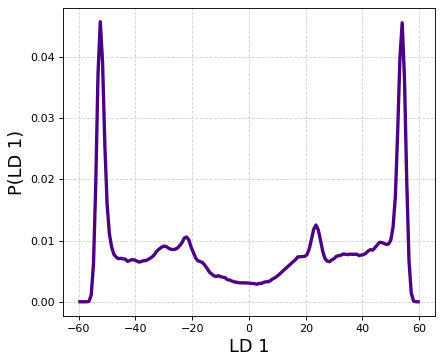

In [7]:
# plot P(LD 1) vs. time
hist,bins = np.histogram(ld1, bins=150, range=[-60,60], density=True)
grids = (bins[:-1]+bins[1:])/2.0

plt.figure(figsize=(6,5), dpi=80)
plt.ylabel("P(LD 1)", fontsize=16)
plt.xlabel("LD 1", fontsize=16)
plt.plot(grids, hist, color="indigo", lw=3.0)
plt.grid(axis="both", which="major", linestyle="--", color="lightgrey")

plt.savefig("prob_ld1_aib9.pdf", format="pdf")

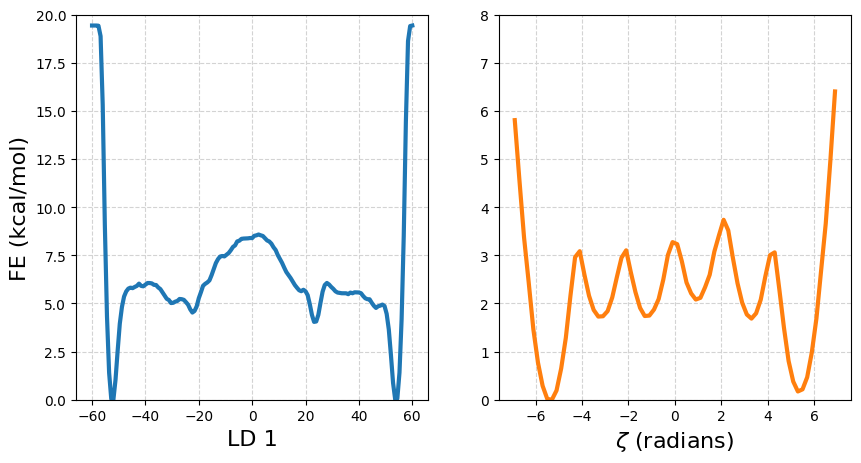

In [8]:
fig, axs = plt.subplots(1,2, figsize=(10,5), dpi=100)

# load fe data
grids, fe = np.loadtxt("/scratch/projects/hockygroup/ss12902/\
wt-metad_sims_aib9/height_0.005_bf_2.0/analysis/fe_vs_ld1.txt", usecols=(0,1), unpack=True)

fe *= (gamma/(gamma-1))

# plot fe vs. ld1
axs[0].set_xlabel("LD 1", fontsize=16)
axs[0].set_ylabel("FE (kcal/mol)", fontsize=16)
axs[0].grid(axis="both", which="major", linestyle="--", color="lightgrey")
axs[0].set_ylim(0.0,20.0)
axs[0].plot(grids, fe, color="tab:blue", lw=3.0)


# plot fe vs. zeta
nbins=70

hist, bins = np.histogram(zeta, bins=nbins, range=[-7,7], density=True, weights=np.exp(meta_rbias[::10]/kbt))
grids = (bins[1:]+ bins[:-1])/2.0
fe = -kbt*np.log(hist)
fe -= fe.min()
axs[1].set_ylim(0.0,8.0)
axs[1].set_xlabel("$\zeta$ (radians)", fontsize=16)
#axs[1].set_ylabel("FE (kcal/mol)", fontsize=16)
axs[1].grid(axis="both", which="major", linestyle="--", color="lightgrey")
axs[1].plot(grids, fe, lw=3.0, color="tab:orange")

plt.savefig("fe_vs_ld1_zeta_from_metad_aib9.pdf", format="pdf")

### Load 1.5 $\mu$s long MD simulation data (ld1 and zeta)

/state/partition1/job-27278240/ipykernel_1359535/2486572553.py:9: RuntimeWarning: divide by zero encountered in log
  fe_md = -kbt*np.log(hist)


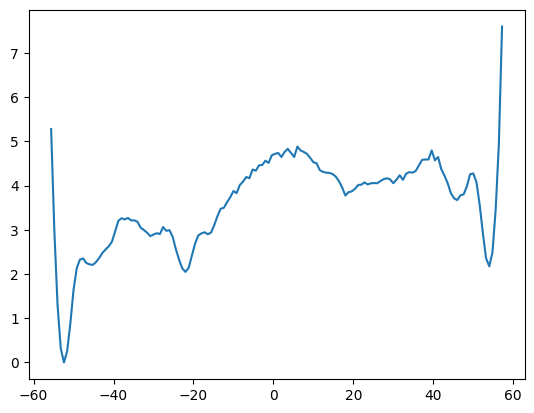

In [9]:
ld1_md, zeta_md = np.loadtxt("/scratch/projects/hockygroup/ss12902/md_sims_aib9/left/long_cmd/COLVAR", usecols=(1,2), unpack=True)

ld1_range = [-60,60]
nbins=150

hist, bins = np.histogram(ld1_md, range=ld1_range, bins=nbins, density=True)
grids_md = (bins[1:]+bins[:-1])/2.0

fe_md = -kbt*np.log(hist)
fe_md -= fe_md.min()

plt.plot(grids_md, fe_md)

## plot LD1 vs. time (MD and wt-metad)

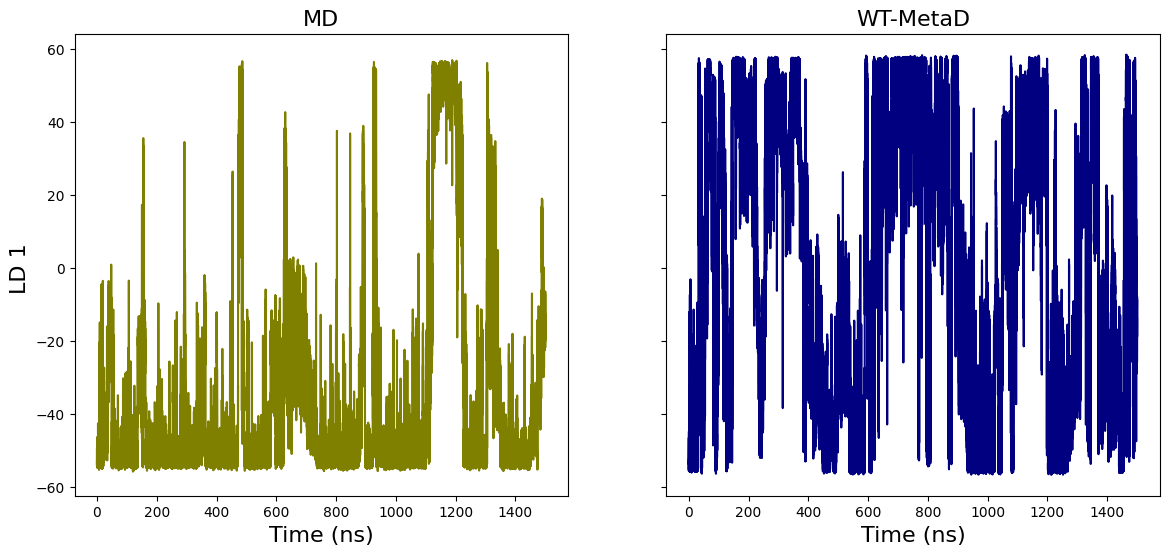

In [10]:
fig, axs = plt.subplots(1,2, sharey=True, sharex=True, figsize=(14,6), dpi=100)

# MD
axs[0].set_title("MD", fontsize=16)
axs[0].set_ylabel("LD 1 ", fontsize=16)
axs[0].set_xlabel("Time (ns)", fontsize=16)
axs[0].plot(np.arange(ld1_md.shape[0])*1e-2, ld1_md, color="olive")

# WT-MetaD
axs[1].set_title("WT-MetaD", fontsize=16)
axs[1].set_xlabel("Time (ns)", fontsize=16)
axs[1].plot(time, ld1, color="navy")

plt.savefig("ld1_vs_time_compare_aib9.pdf", format="pdf")

## plot zeta vs. time (MD and wt-metad)

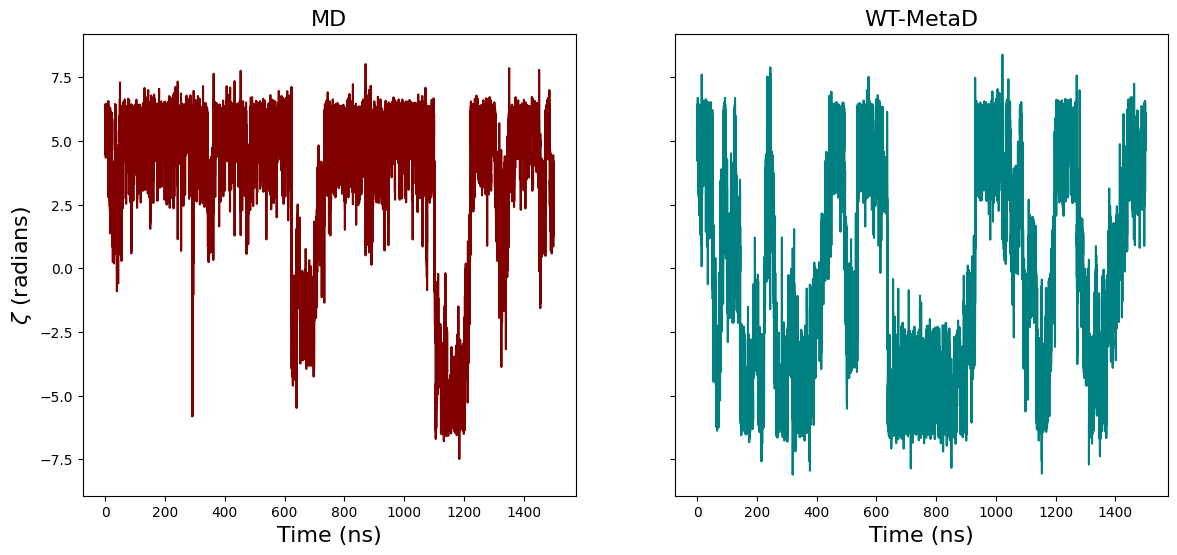

In [11]:
fig, axs = plt.subplots(1,2, sharey=True, sharex=True, figsize=(14,6), dpi=100)

# MD
axs[0].set_title("MD", fontsize=16)
axs[0].set_ylabel("$\\zeta$ (radians)", fontsize=16)
axs[0].set_xlabel("Time (ns)", fontsize=16)
axs[0].plot(np.arange(zeta_md.shape[0])*1e-2, zeta_md, color="maroon")

# WT-MetaD
axs[1].set_title("WT-MetaD", fontsize=16)
axs[1].set_xlabel("Time (ns)", fontsize=16)
axs[1].plot(np.arange(zeta.shape[0])*1e-2, zeta, color="teal")

plt.savefig("zeta_vs_time_compare_aib9.pdf", format="pdf")

## make the vmd script for porcupine plot in AIB9

In [32]:
forFile = "/scratch/projects/hockygroup/ss12902/wt-metad_sims_aib9/height_0.005_bf_2.0/ld1_scalings.txt"
vmdFile = "vmd_porcupine.tcl"

#new_univ = md.Universe("/scratch/projects/hockygroup/ss12902/wt-metad_sims_aib9/height_0.005_bf_2.0/analysis/left.gro")
new_univ = md.Universe("/scratch/projects/hockygroup/ss12902/pLDA_paper_data_final/aib9/left_centered.gro")

atoms = new_univ.select_atoms(backbone_selection_101)
print(atoms.indices.shape)
positions = atoms.positions
print(positions.shape)
forces_data = np.loadtxt(forFile) 

vmdOut = open(vmdFile,"w")
for atom in range(positions.shape[0]):
    forces = forces_data[atom*3:atom*3+3:]
    #mid = positions[atom,:] + 0.5*forces
    mid = positions[atom,:] + 0.8*forces
    end = positions[atom,:] + forces
    vmdOut.write("draw color yellow\n")
    vmdOut.write("draw cylinder {%10.3f %10.3f %10.3f} {%10.3f %10.3f %10.3f} radius 0.15 filled yes\n" % (positions[atom,0],positions[atom,1],positions[atom,2],mid[0],mid[1],mid[2]))
    vmdOut.write("draw color red\n")
    vmdOut.write("draw cone {%10.3f %10.3f %10.3f} {%10.3f %10.3f %10.3f} radius 0.25\n" % (mid[0],mid[1],mid[2],end[0],end[1],end[2]))

vmdOut.close()

(23,)
(23, 3)


## Testing other stuffs for AIB9

## load the 6-state shapeGMM object which Martin sent

In [13]:
#with open("/scratch/projects/hockygroup/ss12902/wt-metad_sims_aib9/height_0.005_bf_2.0/analysis/weighted_sgmm_6_clusters_20k_train_from_Martin.pickle", "rb") as f_o:

#with open("/scratch/projects/hockygroup/ss12902/wt-metad_sims_aib9/height_0.005_bf_2.0/analysis/weighted_sgmm_6_clusters_20k_train_v02.pickle", "rb") as f_o:

with open("/scratch/projects/hockygroup/ss12902/wt-metad_sims_aib9/height_0.005_bf_2.0/analysis/weighted_sgmm_6_clusters_50k_train.pickle", "rb") as f_o:
    wsgmm6 = pickle.load(f_o)

In [14]:
import torch
wsgmm6.device=torch.device('cpu')
clusters, _,_ = wsgmm6.predict(trajData)

In [15]:
cluster_ids, cluster_populations = np.unique(clusters,return_counts=True)
n_clusters = cluster_ids.size

print("Total no. of clusters =", n_clusters)
print("Cluster ID:", cluster_ids)
print("Populations of clusters:", cluster_populations)

Total no. of clusters = 6
Cluster ID: [0 1 2 3 4 5]
Populations of clusters: [14912 32308 41366 22910 19493 19012]


<BarContainer object of 6 artists>

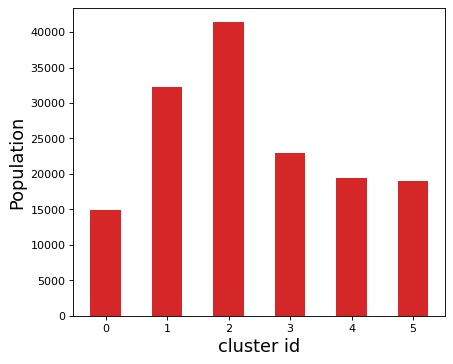

In [16]:
plt.figure(figsize=(6,5), dpi=80)
plt.xlabel("cluster id", fontsize=16)
plt.ylabel("Population", fontsize=16)
plt.bar(cluster_ids, cluster_populations, width=0.5, align="center", color="tab:red")


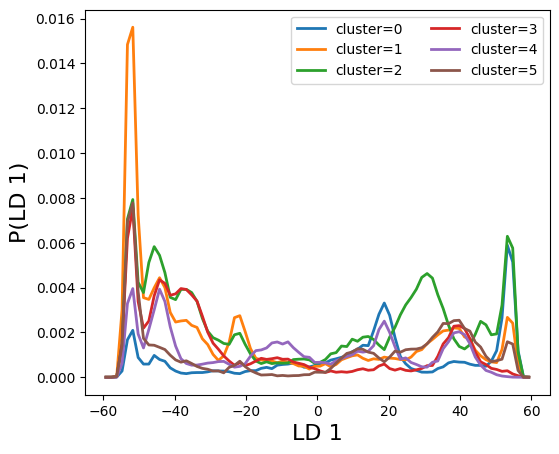

In [17]:
ld_range=[-60,60]
nbins=80

plt.figure(figsize=(6,5), dpi=100)
plt.xlabel("LD 1", fontsize=16)
plt.ylabel("P(LD 1)", fontsize=16)
# looping over clusters
for i in range(wsgmm6.n_clusters):
    
    # extracting LD values corresponding to each state
    ld_i = ld1[[x[0] for x in np.argwhere(clusters == i)]]
    
    # histogramming
    hist_i ,bins = np.histogram(ld_i, range=ld_range, bins=nbins, density=True)
    grids = (bins[1:] + bins[:-1])/2.0
    
    # calculate the weights
    weight = np.argwhere(clusters==i).size/clusters.size
    
    #plot it
    plt.plot(grids, hist_i*weight, label="cluster=%d"%i, lw=2.0)
    #plt.plot(grids, hist_i, label="cluster=%d"%i, lw=2.0)    
    #plt.fill_between(grids, hist_i)
    
plt.legend(loc="upper right", ncol=2, fontsize="medium", markerscale=2.0)

(150001,)


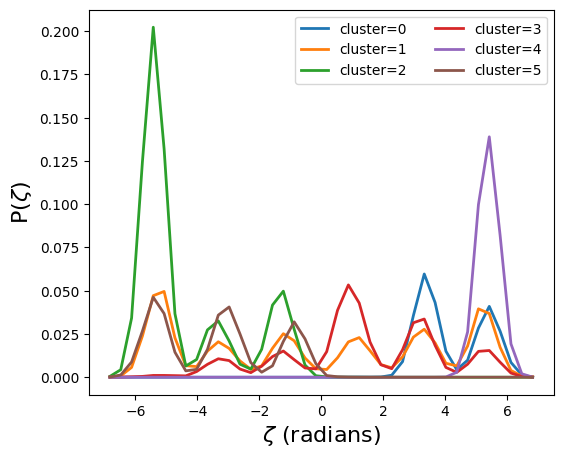

In [29]:
zeta_range=[-7,7]
nbins=40
x_ = clusters[::1]
print(x_.shape)

plt.figure(figsize=(6,5), dpi=100)
plt.xlabel("$\\zeta$ (radians)", fontsize=16)
plt.ylabel("P($\\zeta$)", fontsize=16)
# looping over clusters
for i in range(wsgmm6.n_clusters):
    
    # extracting LD values corresponding to each state
    zeta_i = zeta[[x[0] for x in np.argwhere(x_ == i)]]
    
    # histogramming
    hist_i ,bins = np.histogram(zeta_i, range=zeta_range, bins=nbins, density=True)
    grids = (bins[1:] + bins[:-1])/2.0
    
    # calculate the weights
    weight = np.argwhere(clusters==i).size/clusters.size
    
    #plot it
    plt.plot(grids, hist_i*weight, label="cluster=%d"%i, lw=2.0)
    #plt.plot(grids, hist_i, label="cluster=%d"%i, lw=2.0)    
    #plt.fill_between(grids, hist_i)
    
plt.legend(loc="upper right", ncol=2, fontsize="medium", markerscale=2.0)

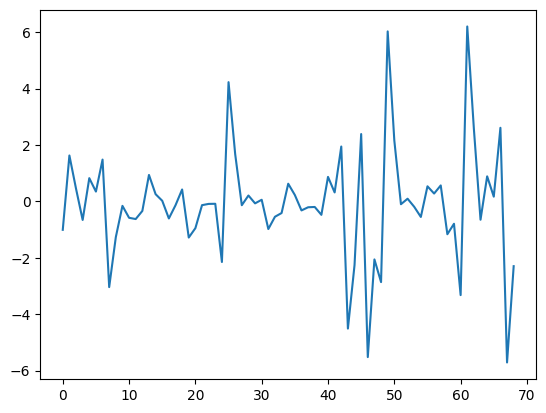

In [30]:
plt.plot(forces_data)